# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [30]:
n_k1 = 8
n_k2 = 2
n_total = n_k1 + n_k2

p_k1 = n_k1 / n_total
p_k2 = n_k2 / n_total

entropy = - (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2))

entropy_rounded = np.round(entropy, 2)
print(entropy_rounded)

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [31]:
import numpy as np

def gini(p):
    return np.sum(p*(1-p))

n_total = 10
n_class1 = 8
n_class2 = 2
probabilities_parent = np.array([n_class1/n_total, n_class2/n_total])
H_parent = gini(probabilities_parent)


#равное распределение
n_left = 5
n_right = 5
probabilities_left = np.array([1.0, 0.0])
probabilities_right = np.array([1.0, 0.0])

H_left = gini(probabilities_left)
H_right = gini(probabilities_right)

Q = H_parent - (n_left/n_total)*H_left - (n_right/n_total)*H_right
Q_rounded = np.round(Q, 2)

Q_rounded

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [32]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

prediction = sum(target_values) / len(target_values)# ср. знач. для всех объектов в листе
prediction

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [33]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [34]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    feature = np.array(feature_vector).flatten()
    target = np.array(target_vector)
    n = len(feature)

    if np.unique(feature).size == 1:
        return np.array([]), np.array([]), 0.0, 0.0

    if feature_type == "real":
        unique = np.unique(feature)
        if len(unique) == 1:
            return np.array([]), np.array([]), 0.0, 0.0
        thresholds = (unique[:-1] + unique[1:]) / 2
    else:
        thresholds = np.unique(feature)

    best_gain = -np.inf
    best_threshold = None
    valid_thresholds = []
    gains = []

    for threshold in thresholds:
        left_mask = feature <= threshold if feature_type == "real" else feature == threshold
        n_left = np.sum(left_mask)
        n_right = n - n_left

        if n_left == 0 or n_right == 0:
            continue

        if task == "classification":
            h_total = gini(target)
            h_left = gini(target[left_mask])
            h_right = gini(target[~left_mask])
        else:
            h_total = variance(target)
            h_left = variance(target[left_mask])
            h_right = variance(target[~left_mask])

        # Расчет информационного выигрыша
        gain = h_total - (n_left/n)*h_left - (n_right/n)*h_right
        valid_thresholds.append(threshold)
        gains.append(gain)

        # Обновление лучшего разбиения
        if gain > best_gain or (gain == best_gain and threshold < best_threshold):
            best_gain = gain
            best_threshold = threshold

    if not valid_thresholds:
        return np.array([]), np.array([]), 0.0, 0.0

    return np.array(valid_thresholds), np.array(gains), best_threshold, best_gain

def gini(y):
    if len(y) == 0:
        return 0.0
    counts = {}
    for val in y:
        counts[val] = counts.get(val, 0) + 1
    return 1 - sum((v/len(y))**2 for v in counts.values())

def variance(y):
    if len(y) < 2:
        return 0.0
    mean = np.mean(y)
    return np.mean((y - mean)**2)




Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [35]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

target = raw_df.values[1::2, 2]

feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]

df = pd.DataFrame(data, columns=feature_names)

df['MEDV'] = target

print(df.shape)
print(df.head())

(506, 14)
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


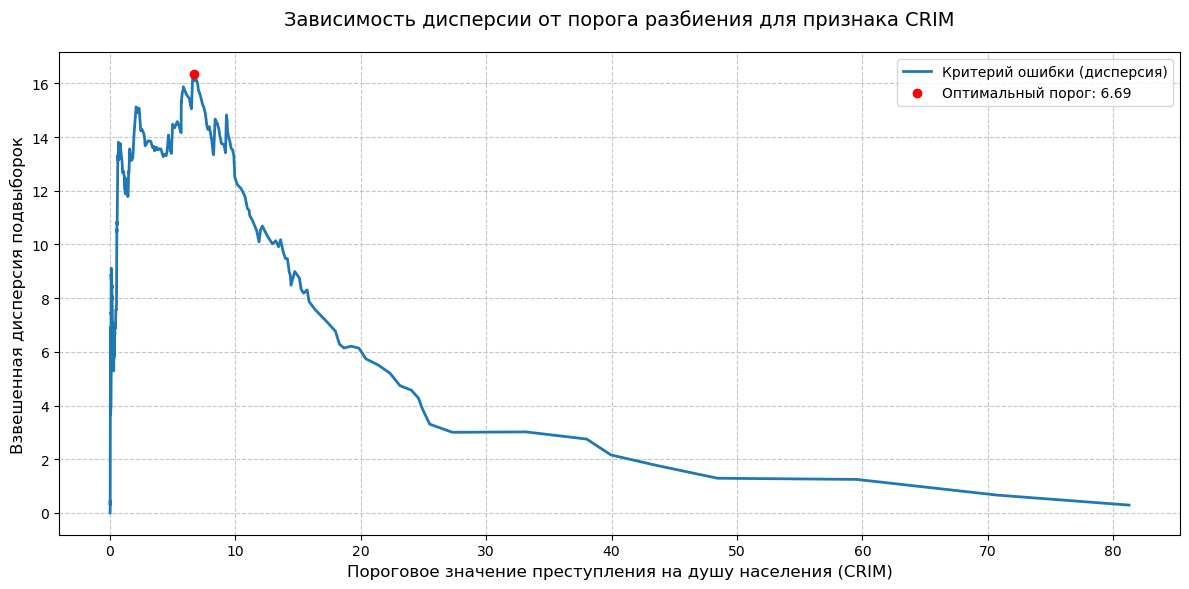

In [36]:
import matplotlib.pyplot as plt
import numpy as np

thresholds, variances, threshold_best, variance_best = find_best_split(
    df["CRIM"].values,
    target,
    task="regression",
    feature_type="real"
)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, variances, linewidth=2, label='Критерий ошибки (дисперсия)')
plt.scatter(threshold_best, variance_best, color='red', zorder=5,
           label=f'Оптимальный порог: {threshold_best:.2f}')

plt.title('Зависимость дисперсии от порога разбиения для признака CRIM', fontsize=14, pad=20)
plt.xlabel('Пороговое значение преступления на душу населения (CRIM)', fontsize=12)
plt.ylabel('Взвешенная дисперсия подвыборок', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [37]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            if x[feature_idx] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

        elif feature_type == "categorical":
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

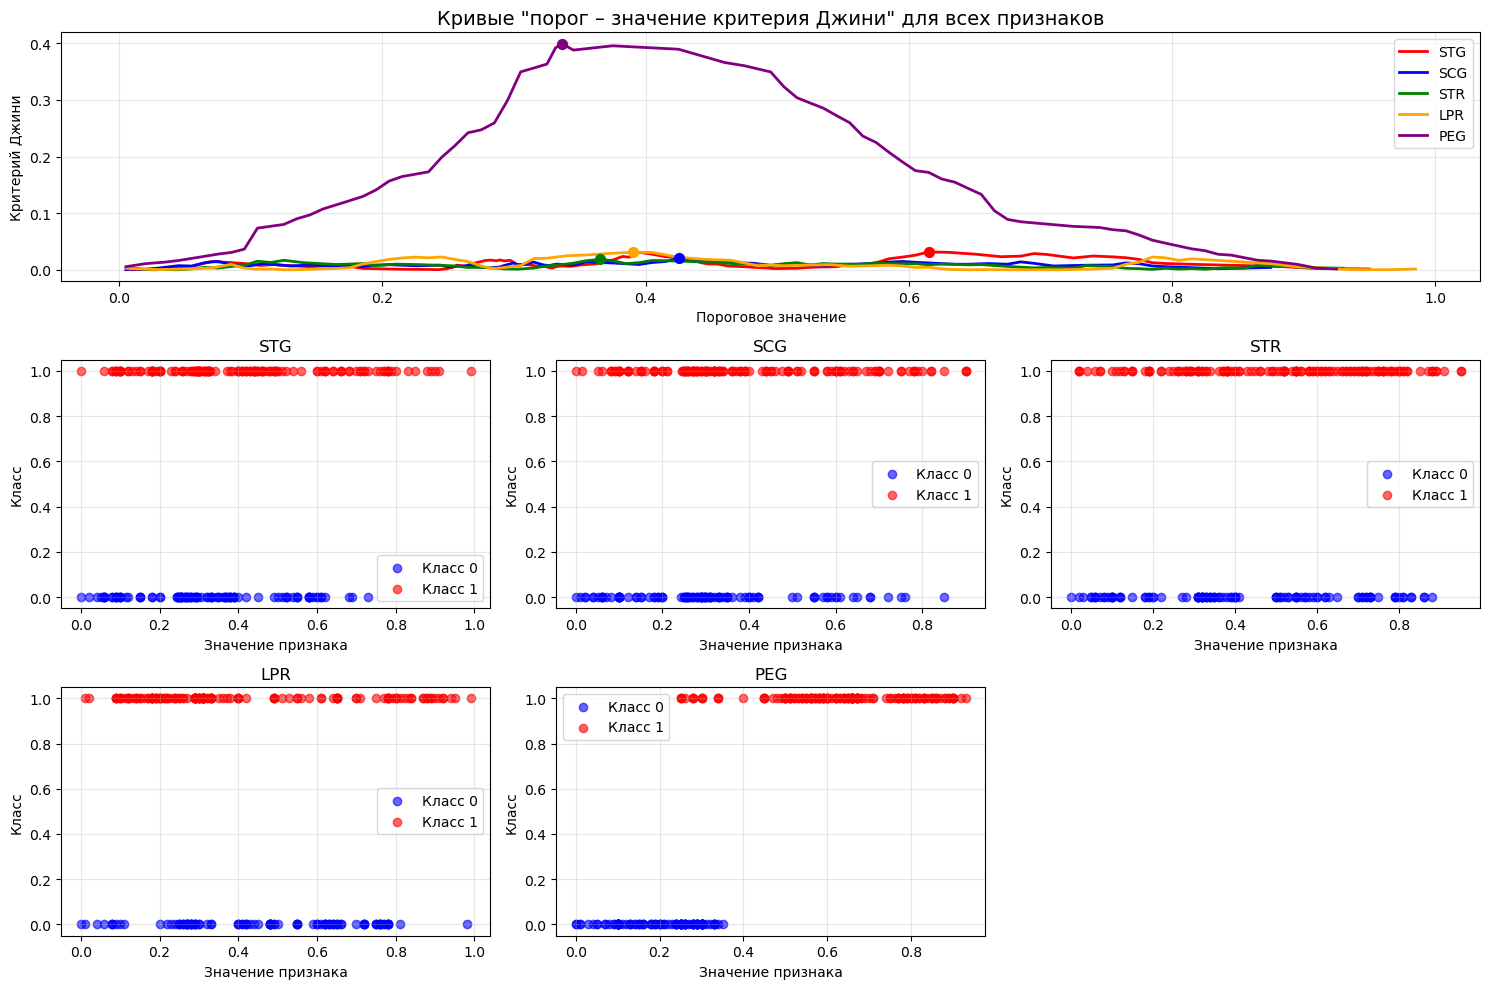

Лучший признак для разбиения: PEG с критерием Джини = 0.39939200196213387


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


students_data = pd.read_csv('students.csv')

feature_columns = [col for col in students_data.columns if col != 'UNS'][1:]
X = students_data[feature_columns].values
y = students_data['UNS'].values

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
colors = ['red', 'blue', 'green', 'orange', 'purple']

best_features = []
for i, feature_name in enumerate(feature_columns):
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        X[:, i], y, task="classification", feature_type="real"
    )

    ax1.plot(thresholds, ginis, color=colors[i], label=f'{feature_name}', linewidth=2)
    ax1.scatter(threshold_best, gini_best, color=colors[i], s=50, zorder=5)

    best_features.append((feature_name, gini_best, threshold_best))

ax1.set_title('Кривые "порог – значение критерия Джини" для всех признаков', fontsize=14)
ax1.set_xlabel('Пороговое значение')
ax1.set_ylabel('Критерий Джини')
ax1.legend()
ax1.grid(True, alpha=0.3)

for i, feature_name in enumerate(feature_columns):

    if i >= 3:
      ax = fig.add_subplot(gs[2, i % 3])
    else:
      ax = fig.add_subplot(gs[1, i % 3])

    class_0 = X[y == 0, i]
    class_1 = X[y == 1, i]

    ax.scatter(class_0, [0] * len(class_0), alpha=0.6, label='Класс 0', color='blue')
    ax.scatter(class_1, [1] * len(class_1), alpha=0.6, label='Класс 1', color='red')

    ax.set_title(f'{feature_name}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Класс')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_features.sort(key=lambda x: x[1], reverse=True)
print(f"Лучший признак для разбиения: {best_features[0][0]} с критерием Джини = {best_features[0][1]}")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [39]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Загрузка данных mushrooms

mushroom_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                               header=None)
mushroom_data.head()
# Применяем LabelEncoder ко всем столбцам
label_encoders = {}
encoded_data = mushroom_data.copy()

for column in mushroom_data.columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(mushroom_data[column])
    label_encoders[column] = le

# Выделяем признаки и целевую переменную
X_mushroom = encoded_data.iloc[:, 1:].values  # Все столбцы кроме первого
y_mushroom = encoded_data.iloc[:, 0].values   # Первый столбец - целевая переменная

# Определяем типы признаков (все категориальные)
feature_types_mushroom = ['categorical'] * X_mushroom.shape[1]

np.random.seed(42)
indices = np.random.permutation(len(X_mushroom))
split_idx = len(X_mushroom) // 2

train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_mushroom[train_indices]
y_train = y_mushroom[train_indices]
X_test = X_mushroom[test_indices]
y_test = y_mushroom[test_indices]

# Обучаем дерево решений
tree = DecisionTree(feature_types=feature_types_mushroom, task="classification")
tree.fit(X_train, y_train)

# Делаем предсказания
y_pred = tree.predict(X_test)

# Вычисляем accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy на тестовой выборке: {accuracy:.4f}")


Accuracy на тестовой выборке: 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [40]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [41]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

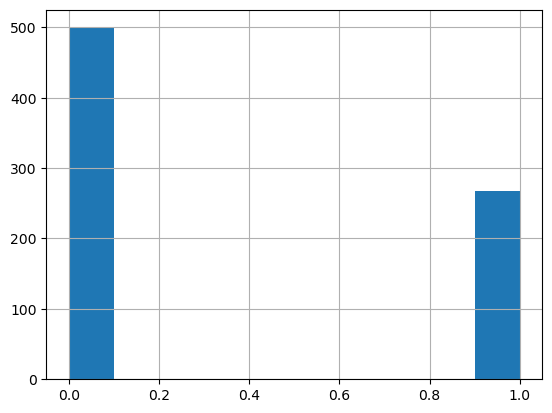

In [42]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [43]:
# Разделение на признаки и целевую переменную
X_diabetes = data.drop('Outcome', axis=1)
y_diabetes = data['Outcome']

# Разделение на обучающую и тестовую выборки (7:3)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=42, stratify=y_diabetes
)

# Разделение обучающей выборки на обучающую-обучающую и обучающую-валидационную (7:3)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

print(f"Размер обучающей-обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X_diabetes):.2f})")
print(f"Размер обучающей-валидационной выборки: {X_val.shape[0]} ({X_val.shape[0]/len(X_diabetes):.2f})")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X_diabetes):.2f})")

Размер обучающей-обучающей выборки: 375 (0.49)
Размер обучающей-валидационной выборки: 162 (0.21)
Размер тестовой выборки: 231 (0.30)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from itertools import product

# Параметры для перебора
max_depth_values = [3, 5, 7, 10, 15, None]
min_samples_leaf_values = [1, 5, 10, 20, 50]

best_f1 = 0
best_params = None

# Перебор всех комбинаций параметров
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        # Обучение дерева на обучающей-обучающей выборке
        dt = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        dt.fit(X_train, y_train)

        # Предсказание на обучающей-валидационной выборке
        y_val_pred = dt.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_params = (max_depth, min_samples_leaf)

print(f"Лучшие параметры: max_depth={best_params[0]}, min_samples_leaf={best_params[1]}")
print(f"Лучший F1-score на валидации: {best_f1:.4f}")

# Обучение лучшего дерева на полной обучающей выборке
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

best_dt = DecisionTreeClassifier(
    max_depth=best_params[0],
    min_samples_leaf=best_params[1],
    random_state=42
)
best_dt.fit(X_full_train, y_full_train)

# Оценка на тестовой выборке
y_test_pred = best_dt.predict(X_test)
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

dt_accuracy = accuracy_score(y_test, y_test_pred)
dt_precision = precision_score(y_test, y_test_pred)
dt_recall = recall_score(y_test, y_test_pred)
dt_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nМетрики Decision Tree на тестовой выборке:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"AUC ROC: {dt_auc:.4f}")


Лучшие параметры: max_depth=5, min_samples_leaf=20
Лучший F1-score на валидации: 0.6250

Метрики Decision Tree на тестовой выборке:
Accuracy: 0.7273
Precision: 0.6452
Recall: 0.4938
AUC ROC: 0.7951


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [45]:
from sklearn.ensemble import BaggingClassifier

# Обучение BaggingClassifier
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_full_train, y_full_train)

# Предсказания на тестовой выборке
y_test_pred_bagging = bagging.predict(X_test)
y_test_proba_bagging = bagging.predict_proba(X_test)[:, 1]

# Метрики
bagging_accuracy = accuracy_score(y_test, y_test_pred_bagging)
bagging_precision = precision_score(y_test, y_test_pred_bagging)
bagging_recall = recall_score(y_test, y_test_pred_bagging)
bagging_auc = roc_auc_score(y_test, y_test_proba_bagging)

print(f"\nМетрики Bagging на тестовой выборке:")
print(f"Accuracy: {bagging_accuracy:.4f}")
print(f"Precision: {bagging_precision:.4f}")
print(f"Recall: {bagging_recall:.4f}")
print(f"AUC ROC: {bagging_auc:.4f}")



Метрики Bagging на тестовой выборке:
Accuracy: 0.7446
Precision: 0.6719
Recall: 0.5309
AUC ROC: 0.8237


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Параметры для перебора
rf_max_depth_values = [3, 5, 7, 10, 15, None]
rf_min_samples_split_values = [2, 5, 10, 20]

best_rf_f1 = 0
best_rf_params = None

# Перебор параметров с кросс-валидацией
for max_depth, min_samples_split in product(rf_max_depth_values, rf_min_samples_split_values):
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Кросс-валидация на полной обучающей выборке
    cv_scores = cross_val_score(rf, X_full_train, y_full_train, cv=5, scoring='f1')
    mean_f1 = cv_scores.mean()

    if mean_f1 > best_rf_f1:
        best_rf_f1 = mean_f1
        best_rf_params = (max_depth, min_samples_split)

print(f"Лучшие параметры RF: max_depth={best_rf_params[0]}, min_samples_split={best_rf_params[1]}")
print(f"Лучший F1-score (CV): {best_rf_f1:.4f}")

# Обучение лучшего Random Forest
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_rf_params[0],
    min_samples_split=best_rf_params[1],
    random_state=42
)
best_rf.fit(X_full_train, y_full_train)

# Оценка на тестовой выборке
y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf)
rf_recall = recall_score(y_test, y_test_pred_rf)
rf_auc = roc_auc_score(y_test, y_test_proba_rf)

print(f"\nМетрики Random Forest на тестовой выборке:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"AUC ROC: {rf_auc:.4f}")

# Сравнение моделей
print(f"\nСравнение моделей:")
print(f"Decision Tree AUC: {dt_auc:.4f}")
print(f"Bagging AUC: {bagging_auc:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")


Лучшие параметры RF: max_depth=5, min_samples_split=5
Лучший F1-score (CV): 0.6446

Метрики Random Forest на тестовой выборке:
Accuracy: 0.7359
Precision: 0.6724
Recall: 0.4815
AUC ROC: 0.8219

Сравнение моделей:
Decision Tree AUC: 0.7951
Bagging AUC: 0.8237
Random Forest AUC: 0.8219


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

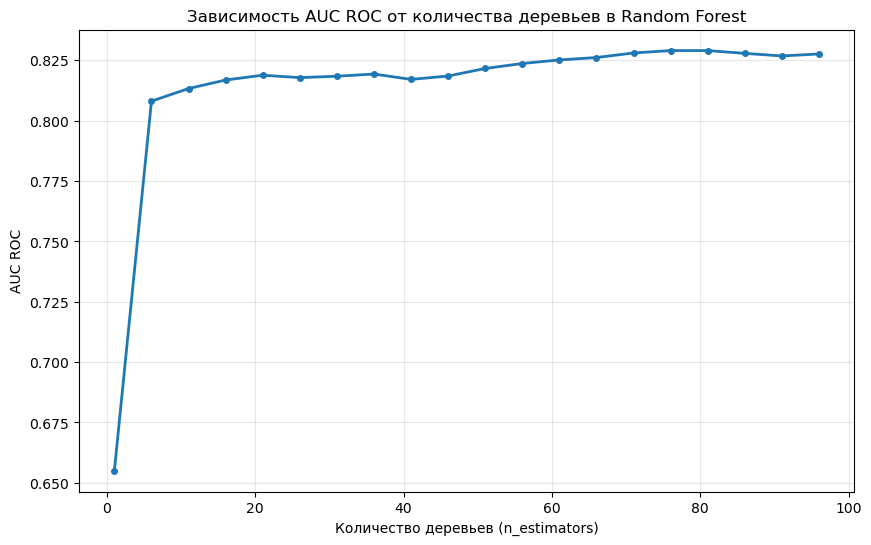

Выводы: С увеличением количества деревьев AUC ROC стабилизируется, что указывает на то, что модель достигает оптимальной производительности.


In [47]:
import matplotlib.pyplot as plt

# Тестируем разное количество деревьев
n_estimators_range = range(1, 101, 5)
auc_scores = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=best_rf_params[0],
        min_samples_split=best_rf_params[1],
        random_state=42
    )
    rf_temp.fit(X_full_train, y_full_train)
    y_proba_temp = rf_temp.predict_proba(X_test)[:, 1]
    auc_temp = roc_auc_score(y_test, y_proba_temp)
    auc_scores.append(auc_temp)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, linewidth=2, marker='o', markersize=4)
plt.title('Зависимость AUC ROC от количества деревьев в Random Forest')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.grid(True, alpha=0.3)
plt.show()

print("Выводы: С увеличением количества деревьев AUC ROC стабилизируется, что указывает на то, что модель достигает оптимальной производительности.")


**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

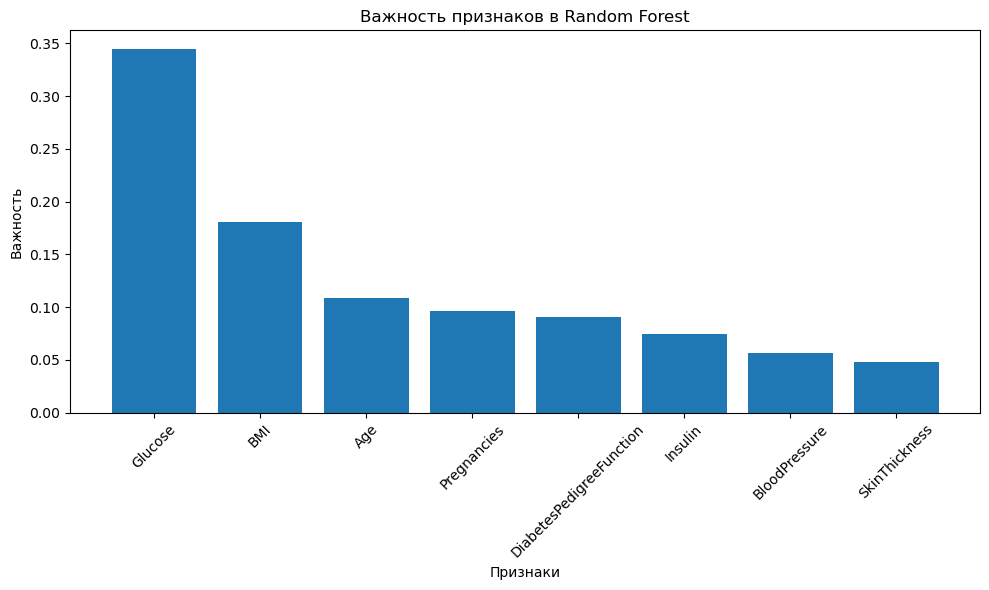

Самый важный признак: Glucose с важностью 0.3451

Ранжирование признаков по важности:
Glucose: 0.3451
BMI: 0.1808
Age: 0.1089
Pregnancies: 0.0963
DiabetesPedigreeFunction: 0.0902
Insulin: 0.0749
BloodPressure: 0.0560
SkinThickness: 0.0478


In [48]:
# Получение важности признаков
feature_importance = best_rf.feature_importances_
feature_names = X_diabetes.columns

# Создание DataFrame для удобства
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Построение bar plot
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.title('Важность признаков в Random Forest')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Самый важный признак: {importance_df.iloc[0]['feature']} с важностью {importance_df.iloc[0]['importance']:.4f}")
print("\nРанжирование признаков по важности:")
for i, row in importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")
